### Run with Spark 3.4 on Python 3.7

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

df = spark.read.csv('Mall_Customers.csv', header=True, inferSchema=True)

df.show(3)

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
+----------+------+---+------------------+----------------------+
only showing top 3 rows



In [25]:
# select important features and drop rows with missing values
df = df.select('Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)').na.drop()

df.show(3)

+------+---+------------------+----------------------+
| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+------+---+------------------+----------------------+
|  Male| 19|                15|                    39|
|  Male| 21|                15|                    81|
|Female| 20|                16|                     6|
+------+---+------------------+----------------------+
only showing top 3 rows



In [26]:
# convert Genre to numerical
df = df.withColumn('Genre', 
                   when(df['Genre'] == 'Male', 0).
                   when(df['Genre'] == 'Female', 1)
									)

df.show(3)

+-----+---+------------------+----------------------+
|Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+-----+---+------------------+----------------------+
|    0| 19|                15|                    39|
|    0| 21|                15|                    81|
|    1| 20|                16|                     6|
+-----+---+------------------+----------------------+
only showing top 3 rows



In [27]:
# # create a vector assembler and standard scaler

cols = df.columns 

df = VectorAssembler(inputCols=cols, outputCol='features').transform(df)

df = StandardScaler(inputCol='features', outputCol='scaled_features').fit(df).transform(df)

df.show(3)

+-----+---+------------------+----------------------+--------------------+--------------------+
|Genre|Age|Annual Income (k$)|Spending Score (1-100)|            features|     scaled_features|
+-----+---+------------------+----------------------+--------------------+--------------------+
|    0| 19|                15|                    39|[0.0,19.0,15.0,39.0]|[0.0,1.3601539142...|
|    0| 21|                15|                    81|[0.0,21.0,15.0,81.0]|[0.0,1.5033280104...|
|    1| 20|                16|                     6| [1.0,20.0,16.0,6.0]|[2.00951470525829...|
+-----+---+------------------+----------------------+--------------------+--------------------+
only showing top 3 rows



In [28]:
# create a kmeans model and fit it to the data
model = KMeans(featuresCol='scaled_features', k=5).fit(df)

df = model.transform(df)

df.show(3)

+-----+---+------------------+----------------------+--------------------+--------------------+----------+
|Genre|Age|Annual Income (k$)|Spending Score (1-100)|            features|     scaled_features|prediction|
+-----+---+------------------+----------------------+--------------------+--------------------+----------+
|    0| 19|                15|                    39|[0.0,19.0,15.0,39.0]|[0.0,1.3601539142...|         4|
|    0| 21|                15|                    81|[0.0,21.0,15.0,81.0]|[0.0,1.5033280104...|         4|
|    1| 20|                16|                     6| [1.0,20.0,16.0,6.0]|[2.00951470525829...|         4|
+-----+---+------------------+----------------------+--------------------+--------------------+----------+
only showing top 3 rows



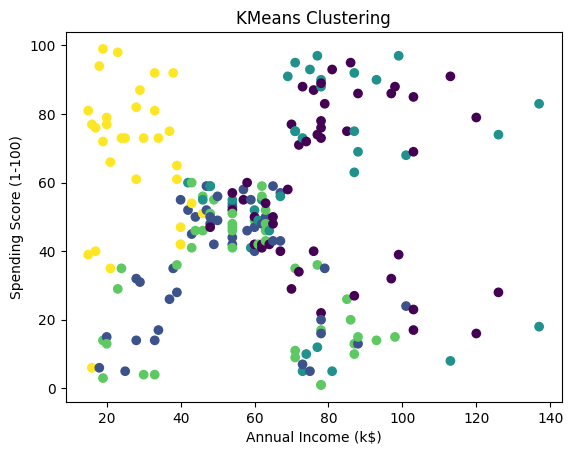

In [29]:
# plot the clusters
df = df.toPandas()

plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['prediction'])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('KMeans Clustering')
plt.show()